# Sarcasm detection and analysis 
 
### Alexander boyev 314393158
### Moshe Faerman 204469449




#### In this project we will try to analyse and predict sarcasm sentences in "Reddit" forum reviews.
#### Reddit is an American social news aggregation, web content rating, and discussion website.

#### The Data contains over 1 million reviews, labeled as sarcastic or not, by binary value.

#### We will use English word embedding FastText to train the deep learning LSTM model


- workflow:
    - Reading the data
    - Preproccesing & Cleaning
    - Tokenize
    - Embedding
    - Padding
    - Shuffle
    - Training the LSTM model
    - Predict




# Import libraries

In [1]:
import os
import torch
import tensorflow as tf

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

print(torch.version.cuda)
print(torch.backends.cudnn.version())

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

11.0
8004
Found GPU at: /device:GPU:0
Num GPUs Available:  1


In [2]:
# import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', -1)

from distutils.version import LooseVersion
import warnings


import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.python.keras.layers import CuDNNLSTM
from sklearn.metrics import classification_report
from keras.models import Model
from keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import random

import os
import re
from tqdm.notebook import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from string import punctuation
import pylab as pl
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import copy
import pickle
import contractions
import stanza
stanza.download('en')
#nlp = stanza.Pipeline(lang='en', processors="tokenize, mwt,pos,lemma",tokenize_no_ssplit=True)

C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.
Using TensorFlow backend.
2020-12-30 13:13:42 INFO: Downloading default packages for language: en (English)...
2020-12-30 13:13:42 INFO: File exists: C:\Users\Alex\stanza_resources\en\default.zip.
2020-12-30 13:13:47 INFO: Finished downloading models and saved to C:\Users\Alex\stanza_resources.


# Variables

In [3]:
sarcasm_data = 0
learning_rate = 0.01
TOTAL_WORDS = 40000
MAX_LEN = 60
val_split = 0.2
stop_words = set(stopwords.words('english')) - {'not', 'nor','no','never','none'}
sarcasticDict = {}
normalDict = {}
embedding_matrix = 0
Adam = optimizers.Adam(lr=learning_rate)
lemmatizer = WordNetLemmatizer()

# Functions

In [4]:
def preprocessing(s):
    #function to lowercase, remove contractions, remove new lines, removes spaces.
    s = str(s).lower().strip()
    expanded_words = []     
    for word in s.split(): 
      # using contractions.fix to expand the shotened words 
      expanded_words.append(contractions.fix(word)) 
    s = " ".join(expanded_words)
    s = re.sub('\n', '', s)
    s = re.sub(r"([?!,+=—&%\'\";:¿।।।|\(\){}\[\]//])", r" \1 ", s)
    s = re.sub('[ ]{2,}', ' ', s).strip()
    return s

# stowords
def stopWords(comment):
    wordnet_lemmatizer = WordNetLemmatizer()
    text_tokens = word_tokenize(comment)
    tokens_without_sw = []
    for word in text_tokens:
        if not word in stop_words:
            if not word in punctuation:
                if not word.isdigit():
                    word = wordnet_lemmatizer.lemmatize(word)
                    tokens_without_sw.append(word)
    
    filtered_sentence = (" ").join(tokens_without_sw)
    return filtered_sentence

def lematize(comment):
    lemmaList = []
    wordnet_lemmatizer = WordNetLemmatizer()
    text_tokens = word_tokenize(comment)
    for word in text_tokens:
        word = wordnet_lemmatizer.lemmatize(word)
        lemmaList.append(word)
    return lemmaList

#frequency
def wordFrequency(comment,status):
    if status == 0:
        for word in comment:
            if word in normalDict:
                counter = normalDict[word] + 1
                normalDict[word] = counter
            else:
                normalDict[word] = 1
    else:
        for word in comment:
            if word in sarcasticDict:
                counter = sarcasticDict[word] + 1
                sarcasticDict[word] = counter
            else:
                sarcasticDict[word] = 1
                
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return lemmatized_sentence
                
def shuffleData(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    tf.random.set_seed(seed)
    
def checkpoint(name:str):
    return ModelCheckpoint(name, monitor='val_binary_accuracy', verbose=1, save_best_only=True,
                                   save_weights_only=False, mode='auto')

def plot(hist:dict,y_title:str,plot_title:str):
    plt.figure(figsize=(6,2),dpi=140,facecolor="w")
    plt.grid(c='black',linestyle="-",linewidth=2)
    plt.ylabel(y_title)
    plt.xlabel("epochs")
    plt.title(plot_title)
    plt.plot(hist)
    
def makeGraph(history):
    acc = history['val_binary_accuracy']
    val_acc = history['binary_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, 'red', label='Training acc')
    plt.plot(epochs, val_acc, 'blue', label='Validation acc')
    plt.legend()

    plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, 'red', label='Training loss')
    plt.plot(epochs, val_loss, 'blue', label='Validation loss')

    plt.legend()

    plt.show()
    
def makeGraphBert(history):
    acc = history['val_accuracy']
    val_acc = history['accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, 'red', label='Training acc')
    plt.plot(epochs, val_acc, 'blue', label='Validation acc')
    plt.legend()

    plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, 'red', label='Training loss')
    plt.plot(epochs, val_loss, 'blue', label='Validation loss')

    plt.legend()

    plt.show()
    
def data_cleaning(rev:str)->str:
    rev = re.sub(re.compile('<.*?>'), "", rev.lower())
    rev = re.sub("'s", " is", rev)
    rev = re.sub("'ve", " have", rev)
    rev = re.sub("n't", " not", rev)
    rev = re.sub("cannot", " can not", rev)
    rev = re.sub("'re", " are", rev)
    rev = re.sub("'d", " would", rev)
    rev = re.sub("'ll", " will", rev)
    rev = re.sub("won\'t", "will not", rev)
    rev = re.sub("can\'t", "can not", rev)
    rev = re.sub("\'t", " not", rev)
    rev = re.sub("\'ve", " have", rev)
    rev = re.sub("\'m", " am", rev)
    rev = re.sub("[^a-z ]+", '', rev.replace('.',' ').replace(',',' '))
    return rev

def remove_bad_words(rev:str)->str:
    temp=""
    for word in rev.split():
        if word not in stop_words and len(set(word))>1:
            temp+=word+ " "
    return temp


def split_into_train_test_dev():
    global sarcasm_data
    temp = {}
    temp['train'], temp['test'] = train_test_split(sarcasm_data, test_size=0.15, random_state=42)
    temp['train'] , temp['dev'] = train_test_split(temp['train'], test_size=0.15, random_state=42)
    sarcasm_data = temp
    
class Dictionary:
    def __init__(self):
        self.word2idx = {"PAD":0}
        self.idx2word = {0:"PAD"}
        self.word2freq = {"PAD":1}
        self.idx = 1
    
    def add_words(self,input):
        def add():
            if word not in self.word2idx.keys():
                self.word2idx[word] = self.idx
                self.idx2word[self.idx] = word
                self.word2freq[word] = 1
                self.idx+=1
            else:
                self.word2freq[word] += 1
       
        def addSeq():
            nonlocal word
            for word in input:
                add()
        inputType = type(input)
        word = []
        if inputType != list and inputType != str and inputType != tuple:
            raise TypeError ("dict at add_word :the type of the input is not allowed")
        if inputType == "str":
            input = [input]
        addSeq()
            
            
    def __getitem__(self,words):
        try:
            if type(words) == str:
                return self.word2idx[words]
            return [self.word2idx[word] for word in words]

        except KeyError:
            return None
    
    def __setitem__(self,word,id):

        if word not in self.word2idx.keys():
            self.word2idx[word] = id 
            self.word2idx[id] = word 
            self.idx+=1

            
    def __len__(self):
        return len(self.word2idx)

def fit_on_train(rev:list)->list:
    dictionary.add_words(rev)
    return rev

def transform(rev:list)->list:
    return [dictionary[word] for word in rev if dictionary[word]]


def build_weight_matrix():
    def init_fast_text():
        nonlocal fastText,dim
        print("Loading FastText pre-trained vectors")
        with open('crawl-300d-2M.vec', 'r', encoding='utf-8', newline='\n',errors='ignore') as f:
            _, dim = map(int, f.readline().split())
            fastText = {}
            for line in f:
                tokens = line.rstrip().split(' ')
                fastText[tokens[0]] = np.asarray(tokens[1:], "float32")
    
    def build_matrix():
        nonlocal weights_matrix
        print("starting to build weight matrix for embedding encoding,  based on FastText pre-trained vectors")
        maching_words = 0
        dataset_size = len(dictionary)+1
        weights_matrix = np.zeros(shape=(dataset_size,dim))
        for i,word in enumerate(dictionary.word2idx.keys(),1):
            try:
                save = fastText[word]
                maching_words += 1
            except KeyError:
                save = np.random.uniform(size=(dim,))
            weights_matrix[i] = save
                     
        print("pre-treind words: {} randomaly initilaized: {}".format(maching_words,dataset_size))     
    fastText,dim,weights_matrix=[],0,[]
    init_fast_text()
    build_matrix()
    sarcasm_data['matrix'] = weights_matrix


    
    


# Data reading & Visualisation

In [5]:
dictionary = Dictionary()

In [6]:
sarcasm_data = pd.read_csv("train-balanced-sarcasm.csv")
print(sarcasm_data.shape)
sarcasm_data.head()

(1010826, 10)


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well."
1,0,You do know west teams play against west teams more than east teams right?,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 seed) did not even carry a good enough record to make the playoffs in the east last year.
2,0,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york nigga"" ones are.",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for that. It was made by our boy EASports_MUT


In [7]:
sarcasm_data.drop(['author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc', 'parent_comment'], axis=1, inplace=True)
# remove empty rows
sarcasm_data.dropna(inplace=True)
sarcasm_data.head()



,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams more than east teams right?
2,0,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1"
3,0,"This meme isn't funny none of the ""new york nigga"" ones are."
4,0,I could use one of those tools.


# Preprocessing

In [8]:
sarcasm_data.comment = sarcasm_data.comment.apply(data_cleaning)
sarcasm_data.comment = sarcasm_data.comment.apply(remove_bad_words) #stop words
sarcasm_data.comment = sarcasm_data.comment.apply(lematize)

<AxesSubplot:>

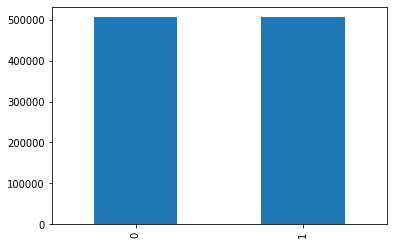

In [9]:
sarcasm_data['label'].value_counts().sort_index().plot.bar()

### The data is pretty much even, 505368 sarcastic sentences and 505405 not sarcastic.

In [10]:
sarcasticComments = sarcasm_data.loc[sarcasm_data['label'] == 1]
normalComments = sarcasm_data.loc[sarcasm_data['label'] == 0 ]


AVGSarcstic = pd.DataFrame([[]])
AVGNormal = pd.DataFrame([[]])

for col in sarcasticComments:
    AVGSarcstic['comment'] = sarcasticComments['comment'].apply(len).mean()
for col in normalComments:
    AVGNormal['comment'] = normalComments['comment'].apply(len).mean()

print("avg length of sarcastic comment: ")
print(AVGSarcstic)
print("avg  length of normal comment: ")
print(AVGNormal)

avg length of sarcastic comment: 
    comment
0  5.671958
avg  length of normal comment: 
    comment
0  5.671974


In [11]:
for i in range(len(sarcasm_data)):
    wordFrequency(sarcasm_data['comment'].iloc[i],sarcasm_data['label'].iloc[i])

In [12]:
try:
    del normalDict["``"]
    del normalDict["..."]
    del sarcasticDict["``"]
    del sarcasticDict["..."]
except: 
    pass
normalDictList = {k: v for k, v in sorted(normalDict.items(), key=lambda item: item[1],reverse=True)}
sarcastictDictList = {k: v for k, v in sorted(sarcasticDict.items(), key=lambda item: item[1],reverse=True)}

normalList = list(normalDictList.keys())
sarcasticList = list(sarcastictDictList.keys())

normalString = ' '.join(normalList)
sarcasticString = ' '.join(sarcasticList)

# Top 10 words in normal sentences

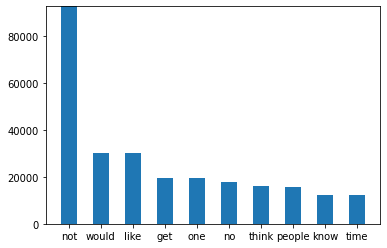

In [13]:
plotList = list(normalDictList)[:10]
plotDict = {}
for word in plotList:
    plotDict[word] = normalDictList[word]

X = np.arange(len(plotDict))
pl.bar(X, plotDict.values(), align='center', width=0.5)
pl.xticks(X, plotDict.keys())
ymax = max(plotDict.values()) + 1
pl.ylim(0, ymax)
pl.show()

# Top 10 words in sarcastic sentences

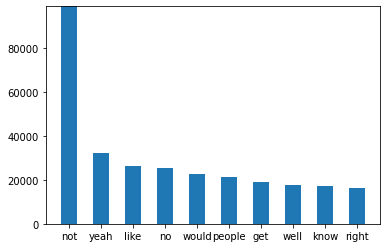

In [14]:
plotList = list(sarcastictDictList)[:10]
plotDict = {}
for word in plotList:
    plotDict[word] = sarcastictDictList[word]

X = np.arange(len(plotDict))
pl.bar(X, plotDict.values(), align='center', width=0.5)
pl.xticks(X, plotDict.keys())
ymax = max(plotDict.values()) + 1
pl.ylim(0, ymax)
pl.show()

# Normal WordCloud

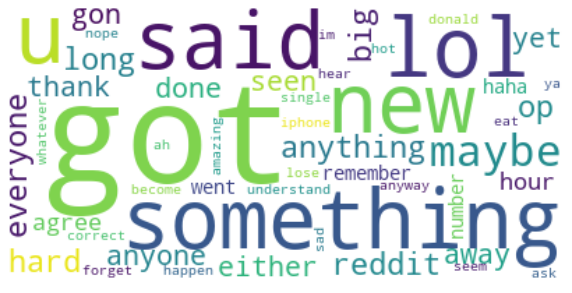

In [15]:
wordcloud = WordCloud(max_font_size=100, max_words=50, background_color="white").generate(normalString)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Sarcastic WordCloud

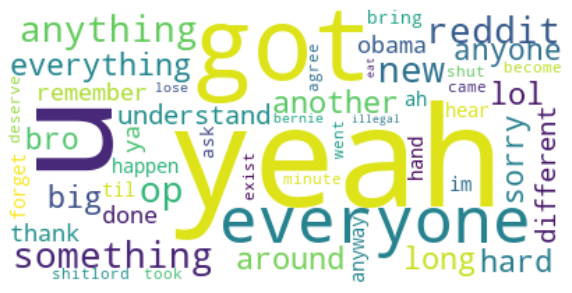

In [16]:
wordcloud = WordCloud(max_font_size=100, max_words=50, background_color="white").generate(sarcasticString)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Shuffle the data

In [17]:
sarcasm_data = sarcasm_data.sample(frac = 1) 

# Lets save the data before embedding.

In [18]:
with open("sarcasm_data_NOTEmbedded.pickle","wb") as f:
     pickle.dump(sarcasm_data,f,protocol=pickle.HIGHEST_PROTOCOL)

# Splitting the data into train 80%  and 20% test

In [ ]:
sarcasm_data = {}
with open('sarcasm_data_NOTEmbedded.pickle',"rb") as f:
     sarcasm_data = pickle.load(f)

In [19]:
split_into_train_test_dev()

sarcasm_data["train"].comment.apply(fit_on_train)
max_len = sarcasm_data["train"].comment.apply(len).max()

for set in ["train","test","dev"]:     
    sarcasm_data[set].comment = sarcasm_data[set].comment.apply(transform)
    sarcasm_data[set].comment = sarcasm_data[set].comment.apply(lambda rev:rev+[0]
                                                      *(max_len-len(rev)) 
                                   if len(rev)<max_len else rev[:max_len])
    sarcasm_data[set] ={"X":np.array(sarcasm_data[set].comment.to_list()),"Y":np.array(sarcasm_data[set].label.to_list())}  

# Build matrix from pretrained FastText Vectors.

In [20]:
build_weight_matrix()

Loading FastText pre-trained vectors
starting to build weight matrix for embedding encoding,  based on FastText pre-trained vectors
pre-treind words: 30199 randomaly initilaized: 37339


In [21]:
sarcasm_data['dict'] = dictionary

# Save the data

In [22]:
with open("sarcasm_data.pickle","wb") as f:
     pickle.dump(sarcasm_data,f,protocol=pickle.HIGHEST_PROTOCOL)

# Load the data

In [5]:
dictionary = Dictionary()
sarcasm_data = {}
with open('sarcasm_data.pickle',"rb") as f:
     sarcasm_data = pickle.load(f)

## Building LSTM model

In [9]:

model = tf.keras.Sequential([Embedding(len(sarcasm_data['dict'])+1 , 128),
                    Bidirectional(CuDNNLSTM(128,return_sequences = True),name="bi-lstm"),
                    GlobalMaxPool1D(),
                    Dense(64, activation="relu"),
                    Dropout(0.5),
                    Dense(32, activation="relu"),
                    Dropout(0.5),
                    Dense(1, activation='sigmoid',name='classifyer')],name="LSTM-128-TEST")

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])
model.summary()


Model: "LSTM-128-TEST"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         17895680  
_________________________________________________________________
bi-lstm (Bidirectional)      (None, None, 256)         264192    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)              

In [10]:
with tf.device('gpu'):
    history = model.fit(sarcasm_data['train']['X'],
    sarcasm_data['train']['Y'],
    batch_size=10,
    epochs=8,
    validation_data=(sarcasm_data['dev']['X'],sarcasm_data['dev']['Y']),
    callbacks=[checkpoint('Sarcasm_LSTM.h5')],
    verbose=1)

Train on 730283 samples, validate on 128874 samples
Epoch 1/8
730280/730283 [============================>.] - ETA: 0s - loss: 0.5965 - binary_accuracy: 0.6821
Epoch 00001: val_binary_accuracy improved from -inf to 0.69231, saving model to Sarcasm_LSTM.h5
730283/730283 [==============================] - 16631s 23ms/sample - loss: 0.5965 - binary_accuracy: 0.6821 - val_loss: 0.5767 - val_binary_accuracy: 0.6923
Epoch 2/8
730280/730283 [============================>.] - ETA: 0s - loss: 0.5379 - binary_accuracy: 0.7346
Epoch 00002: val_binary_accuracy did not improve from 0.69231
730283/730283 [==============================] - 15115s 21ms/sample - loss: 0.5379 - binary_accuracy: 0.7346 - val_loss: 0.5923 - val_binary_accuracy: 0.6866
Epoch 3/8
730280/730283 [============================>.] - ETA: 0s - loss: 0.4986 - binary_accuracy: 0.7587- ETA: 1s - loss: 0.4986 - binary_accuracy: 0
Epoch 00003: val_binary_accuracy did not improve from 0.69231
730283/730283 [============================

In [18]:
with open("history.pickle","wb") as f:
     pickle.dump(history.history,f,protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
best_model = load_model('Sarcasm_LSTM.h5')
history = {}
pred = {}
with open('history.pickle',"rb") as f:
     history = pickle.load(f)
with open('pred.pickle',"rb") as f:
     pred = pickle.load(f)

In [16]:
print(classification_report(sarcasm_data['test']['Y'], pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.69      0.70      0.69     75686
    Sarcastic       0.70      0.69      0.70     75930

     accuracy                           0.69    151616
    macro avg       0.69      0.69      0.69    151616
 weighted avg       0.69      0.69      0.69    151616



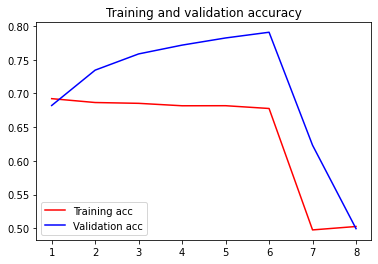

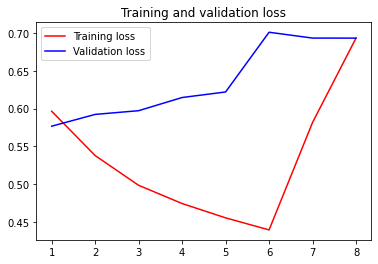

In [22]:
makeGraph(history)

# Trying to imrpove the model, lets add more layers and learning rate.

In [42]:
from tensorflow.keras.optimizers import RMSprop
learning_rate = 0.001
decay = 1e-6
opt = RMSprop(lr=learning_rate, decay=decay)

In [43]:
model = tf.keras.Sequential([Embedding(len(sarcasm_data['dict'])+1 , 256),
                    Bidirectional(CuDNNLSTM(256,return_sequences = True),name="bi-lstm"),
                    GlobalMaxPool1D(),
                    Dense(128, activation="relu"),
                    Dropout(0.5),
                    Dense(64, activation="relu"),
                    Dropout(0.5),
                    Dense(32, activation="relu"),
                    Dropout(0.5),
                    Dense(1, activation='sigmoid',name='classifyer')],name="LSTM-256-TEST")

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['binary_accuracy'])
model.summary()

Model: "LSTM-256-TEST"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 256)         35791360  
_________________________________________________________________
bi-lstm (Bidirectional)      (None, None, 512)         1052672   
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)              

In [21]:
with tf.device('gpu'):
    history = model.fit(sarcasm_data['train']['X'],
    sarcasm_data['train']['Y'],
    batch_size=10,
    epochs=8,
    validation_data=(sarcasm_data['dev']['X'],sarcasm_data['dev']['Y']),
    callbacks=[checkpoint('Sarcasm_LSTM_LR.h5')],
    verbose=1)

Train on 730283 samples, validate on 128874 samples
Epoch 1/8
730280/730283 [============================>.] - ETA: 0s - loss: 0.6735 - binary_accuracy: 0.6412
Epoch 00001: val_binary_accuracy improved from -inf to 0.66884, saving model to Sarcasm_LSTM_LR.h5
730283/730283 [==============================] - 19247s 26ms/sample - loss: 0.6735 - binary_accuracy: 0.6412 - val_loss: 0.7003 - val_binary_accuracy: 0.6688
Epoch 2/8
730280/730283 [============================>.] - ETA: 0s - loss: 0.7042 - binary_accuracy: 0.6349
Epoch 00002: val_binary_accuracy improved from 0.66884 to 0.67212, saving model to Sarcasm_LSTM_LR.h5
730283/730283 [==============================] - 20291s 28ms/sample - loss: 0.7042 - binary_accuracy: 0.6349 - val_loss: 0.6593 - val_binary_accuracy: 0.6721
Epoch 3/8
730280/730283 [============================>.] - ETA: 0s - loss: 0.6997 - binary_accuracy: 0.5511
Epoch 00003: val_binary_accuracy did not improve from 0.67212
730283/730283 [==============================

In [28]:
with open("history-LR.pickle","wb") as f:
     pickle.dump(history.history,f,protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
best_model = load_model('Sarcasm_LSTM_LR.h5')

In [29]:
with open('history-LR.pickle',"rb") as f:
     history = pickle.load(f)

In [24]:
pred=best_model.predict_classes(sarcasm_data['test']['X'])

In [31]:
with open("pred-LR.pickle","wb") as f:
     pickle.dump(pred,f,protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
print(classification_report(sarcasm_data['test']['Y'], pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.65      0.77      0.70     75686
    Sarcastic       0.71      0.58      0.64     75930

     accuracy                           0.67    151616
    macro avg       0.68      0.67      0.67    151616
 weighted avg       0.68      0.67      0.67    151616



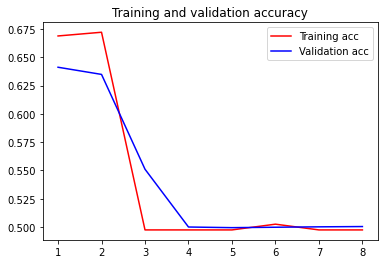

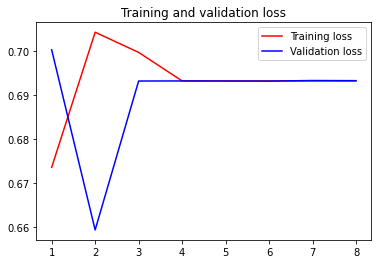

In [30]:
makeGraph(history)

# Trying to add embbedding weights.

In [45]:
model = tf.keras.Sequential([Embedding(len(sarcasm_data['dict'])+1 , 300,weights=[sarcasm_data['matrix'][:150000]]),
                    Bidirectional(CuDNNLSTM(128,return_sequences = True),name="bi-lstm"),
                    GlobalMaxPool1D(),
 
                    Dense(64, activation="relu"),
                    Dropout(0.5),
                    Dense(32, activation="relu"),
                    Dropout(0.5),
                    Dense(1, activation='sigmoid',name='classifyer')],name="LSTM-128-TEST_Weights")

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])
model.summary()

Model: "LSTM-128-TEST_Weights"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 300)         41943000  
_________________________________________________________________
bi-lstm (Bidirectional)      (None, None, 256)         440320    
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)      

In [46]:
with tf.device('gpu'):
    history = model.fit(sarcasm_data['train']['X'][:150000],
    sarcasm_data['train']['Y'][:150000],
    batch_size=10,
    epochs=8,
    validation_data=(sarcasm_data['dev']['X'][:26471],sarcasm_data['dev']['Y'][:26471]),
    callbacks=[checkpoint('LSTM-128-TEST_Weights.h5')],
    verbose=1)

Train on 150000 samples, validate on 26471 samples
Epoch 1/8
149990/150000 [============================>.] - ETA: 0s - loss: 0.6265 - binary_accuracy: 0.6478
Epoch 00001: val_binary_accuracy improved from -inf to 0.67689, saving model to LSTM-128-TEST_Weights.h5
150000/150000 [==============================] - 6195s 41ms/sample - loss: 0.6265 - binary_accuracy: 0.6478 - val_loss: 0.6048 - val_binary_accuracy: 0.6769
Epoch 2/8
149990/150000 [============================>.] - ETA: 0s - loss: 0.5556 - binary_accuracy: 0.7227
Epoch 00002: val_binary_accuracy did not improve from 0.67689
150000/150000 [==============================] - 5182s 35ms/sample - loss: 0.5556 - binary_accuracy: 0.7227 - val_loss: 0.6024 - val_binary_accuracy: 0.6729
Epoch 3/8
149990/150000 [============================>.] - ETA: 0s - loss: 0.4810 - binary_accuracy: 0.7753
Epoch 00003: val_binary_accuracy did not improve from 0.67689
150000/150000 [==============================] - 5594s 37ms/sample - loss: 0.4810 

In [47]:
with open("history_weighted.pickle","wb") as f:
     pickle.dump(history.history,f,protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
best_model = load_model('LSTM-128-TEST_Weights.h5')

In [7]:
with open('history_weighted.pickle',"rb") as f:
     history = pickle.load(f)

In [8]:
pred=best_model.predict_classes(sarcasm_data['test']['X'][:26471])

In [9]:
with open("pred_weights.pickle","wb") as f:
     pickle.dump(pred,f,protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
print(classification_report(sarcasm_data['test']['Y'][:26471], pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.65      0.78      0.71     13342
    Sarcastic       0.72      0.58      0.64     13129

     accuracy                           0.68     26471
    macro avg       0.69      0.68      0.68     26471
 weighted avg       0.69      0.68      0.68     26471



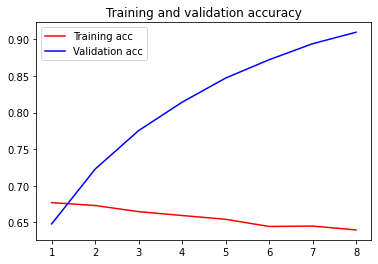

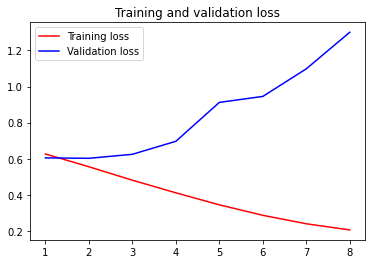

In [13]:
makeGraph(history)

# Lets try BERT model

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

import pickle
import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Input
from tensorflow.keras.models import Model
import torch
import transformers

from tensorflow.keras.callbacks import ModelCheckpoint
def checkpointBert(name:str):
    return ModelCheckpoint(name,save_format='tf', monitor='val_accuracy', verbose=1, save_best_only=True,
                                   save_weights_only=False, mode='auto')

In [52]:
sarcasm_data = {}
with open('sarcasm_data_NOTEmbedded.pickle',"rb") as f:
     sarcasm_data = pickle.load(f)

In [23]:
def join(comment):
    comment= ' '.join(comment)
    return comment

In [54]:
sarcasm_data.comment = sarcasm_data.comment.apply(join)

In [55]:
sarcastic = sarcasm_data.loc[sarcasm_data['label'] == 1]
normal = sarcasm_data.loc[sarcasm_data['label'] == 0]

sarcastic = sarcastic.sample(frac = 1)
normal = normal.sample(frac = 1) 

sarcasm_data = 0
sarcasm_data = pd.concat([normal,sarcastic])

sarcasm_data = sarcasm_data.sample(frac = 1) 

labels = sarcasm_data['label']
sentences = sarcasm_data['comment']
sarcasm_data.head()

,label,comment
957513,0,guy would like marry
133462,0,internet connectivity issue
330886,1,finally someone knowhow turn yahoo around
995298,1,different
521678,1,nah sure thing


In [56]:
X_train,X_test,y_train,y_test = train_test_split(sentences,labels,random_state = 0 , stratify = labels,test_size=0.15)

In [22]:
from tokenizers import BertWordPieceTokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased' , lower = True)
tokenizer.save_pretrained('.')
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)


In [21]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=100):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [59]:
x_train = fast_encode(X_train.values, fast_tokenizer, maxlen=100)
x_test = fast_encode(X_test.values, fast_tokenizer, maxlen=100)

In [60]:
def build_model(transformer, max_len=100):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [61]:
bert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

In [62]:
model = build_model(bert_model, max_len=100)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 100)]             0         
_________________________________________________________________
tf_distil_bert_model_3 (TFDi ((None, 100, 768),)       66362880  
_________________________________________________________________
tf_op_layer_strided_slice_3  [(None, 768)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 769       
Total params: 66,363,649
Trainable params: 66,363,649
Non-trainable params: 0
_________________________________________________________________


In [63]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

In [64]:
with tf.device('gpu'):
    history = model.fit(x_train,
                        y_train,
                        batch_size = 10,
                        validation_data=(x_test,y_test),
                        epochs = 3)

Train on 859157 samples, validate on 151616 samples
Epoch 1/3
859157/859157 [==============================] - 7993s 9ms/sample - loss: 0.5753 - accuracy: 0.6938 - val_loss: 0.5545 - val_accuracy: 0.7123
Epoch 2/3
859157/859157 [==============================] - 7626s 9ms/sample - loss: 0.5281 - accuracy: 0.7339 - val_loss: 0.5503 - val_accuracy: 0.7154
Epoch 3/3
859157/859157 [==============================] - 7633s 9ms/sample - loss: 0.4786 - accuracy: 0.7698 - val_loss: 0.5613 - val_accuracy: 0.7138


# Save BERT model

In [65]:
model.save('C:/Users/Alex/')

INFO:tensorflow:Assets written to: C:/Users/Alex/assets


In [66]:
with open("history_Bert.pickle","wb") as f:
     pickle.dump(history.history,f,protocol=pickle.HIGHEST_PROTOCOL)

# Load BERT model

In [6]:
restored_keras_model = tf.keras.models.load_model('C:/Users/Alex/')

In [7]:
history = 0
with open('history_Bert.pickle',"rb") as f:
     history = pickle.load(f)

In [69]:
pred = restored_keras_model.predict(x_test)
pred = np.round(pred).astype(int)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.69      0.77      0.73     75811
           1       0.74      0.66      0.70     75805

    accuracy                           0.71    151616
   macro avg       0.72      0.71      0.71    151616
weighted avg       0.72      0.71      0.71    151616



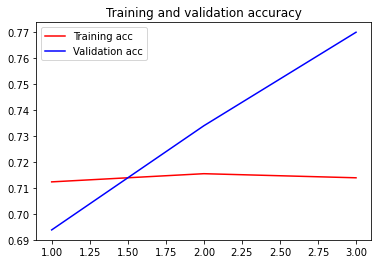

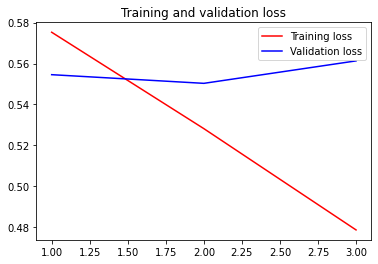

In [73]:
makeGraphBert(history)

# Voting Classifier Test

In [9]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC

In [10]:
log_clf = LogisticRegression(solver='lbfgs', max_iter=1000)
rnd_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()
svm_clf = LinearSVC(random_state=0, tol=1e-5,max_iter=25000)

In [30]:
vot_clf = VotingClassifier(estimators = [('lr', log_clf), ('rnd', rnd_clf), ('knn', knn_clf),('svm',svm_clf)], voting = 'soft')

In [11]:
sarcasm_data = {}
with open('sarcasm_data_NOTEmbedded.pickle',"rb") as f:
     sarcasm_data = pickle.load(f)
sarcasm_data.comment = sarcasm_data.comment.apply(join)
sarcasm_data = sarcasm_data.sample(frac = 1) 

In [12]:
testSentences = sarcasm_data['comment']
testLabels = sarcasm_data['label']
testSentences = fast_encode(testSentences.values, fast_tokenizer, maxlen=100)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(testSentences, testLabels, random_state = 42, train_size = 0.85)

In [14]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
x_train = scaling.transform(x_train)
x_test = scaling.transform(x_test)

In [ ]:
vot_clf.fit(x_train, y_train)

In [ ]:
with open("vot_clf.pickle","wb") as f:
     pickle.dump(vot_clf,f,protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
vot_clf = {}
with open('vot_clf.pickle',"rb") as f:
     vot_clf = pickle.load(f)

In [16]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf,knn_clf, vot_clf):
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    with open('%s.pickle' % clf.__class__.__name__,"wb") as f:
        pickle.dump(y_pred,f,protocol=pickle.HIGHEST_PROTOCOL)
    print(clf.__class__.__name__, accuracy_score(y_test,y_pred))

LogisticRegression 0.5299704516673702
RandomForestClassifier 0.5946404073448712
LinearSVC 0.529891304347826
KNeighborsClassifier 0.5460769311945969
VotingClassifier 0.5395868509919798


In [17]:
BI_LSTM = load_model('Sarcasm_LSTM.h5') #69.2%
BI_STLM_WEIGHTS = load_model('LSTM-128-TEST_Weights.h5') #68.2%
BERT = tf.keras.models.load_model('C:/Users/Alex/') #71.5%


In [50]:
sarcasm_data = {}
with open('sarcasm_data_NOTEmbedded.pickle',"rb") as f:
     sarcasm_data = pickle.load(f)
sarcasm_data.comment = sarcasm_data.comment.apply(join)
sarcasm_data = sarcasm_data.sample(frac = 1) 

In [51]:
testSentences = sarcasm_data['comment'][:200000]
testSentences = fast_encode(testSentences.values, fast_tokenizer, maxlen=100)

In [52]:
BI_LSTMpredictions = BI_LSTM.predict_classes(testSentences)

In [53]:
with open("BI_LSTMpredictions.pickle","wb") as f:
     pickle.dump(BI_LSTMpredictions,f,protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
BI_STLM_WEIGHTSprediction = BI_STLM_WEIGHTS.predict_classes(testSentences)

In [55]:
with open("BI_STLM_WEIGHTSprediction.pickle","wb") as f:
     pickle.dump(BI_STLM_WEIGHTSprediction,f,protocol=pickle.HIGHEST_PROTOCOL)

In [56]:
BERTprediction = BERT.predict(testSentences)

In [57]:
with open("BERTprediction.pickle","wb") as f:
     pickle.dump(BERTprediction,f,protocol=pickle.HIGHEST_PROTOCOL)

In [58]:
BERTprediction = {}
BI_LSTM_WEIGHTSprediction = {}
BI_LSTMpredictions = {}

with open('BI_LSTMpredictions.pickle',"rb") as f:
     BI_LSTMpredictions = pickle.load(f)
with open('BI_STLM_WEIGHTSprediction.pickle',"rb") as f:
     BI_LSTM_WEIGHTSprediction = pickle.load(f)
with open('BERTprediction.pickle',"rb") as f:
     BERTprediction = pickle.load(f)

In [59]:
def normalizePropability(model):
    listValues = []
    for pred in range(len(model)):
        if model[pred] >= 0.50:
            listValues.append(1)
        else:
            listValues.append(0)
    return listValues

In [60]:
BERTlist = normalizePropability(BERTprediction)
BI_LSTM_WEIGHTSlist = normalizePropability(BI_LSTM_WEIGHTSprediction)
BI_LSTMlist = normalizePropability(BI_LSTMpredictions)

In [61]:
# 3 models -> majority is 2.
from collections import Counter
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

models = [BERTlist, BI_LSTM_WEIGHTSlist, BI_LSTMlist]

modelDict = {}
modelDict['BERTlist'] = 0
modelDict['BI_LSTM_WEIGHTSlist'] = 0
modelDict['BI_LSTMlist'] = 0

for i in range(len(BERTlist)):
    majorList = []
    for model in models:
        majorList.append(model[i])
        
    majorNum = Counter(majorList)
    majorNum = majorNum.most_common(1)[0][0]
    
    for model in models:
        if model[i] == majorNum:
            modelDict[namestr(model,globals())[0]] += 1

for model in models:
    modelDict[namestr(model,globals())[0]] /= len(model) 

# Voting classifiers based on our models

In [89]:
print(modelDict)

{'BERTlist': 0.872795, 'BI_LSTMlist': 0.75432, 'BI_LSTM_WEIGHTSlist': 0.7264}


# Majority test

In [26]:
BERT_MODEL = tf.keras.models.load_model('C:/Users/Alex/')

In [32]:
sarcasm_data = {}
with open('sarcasm_data_NOTEmbedded.pickle',"rb") as f:
     sarcasm_data = pickle.load(f)
sarcasm_data.comment = sarcasm_data.comment.apply(join)
sarcasm_data = sarcasm_data.sample(frac = 1) 

## Lets try 60% sarcastic and 40% normal.

In [28]:
sarcastic = sarcasm_data.loc[sarcasm_data['label'] == 1]
normal = sarcasm_data.loc[sarcasm_data['label'] == 0]

sarcastic = sarcastic.sample(120000)
normal = normal.sample(80000) 

sarcasm_data = 0
sarcasm_data = pd.concat([normal,sarcastic])

sarcasm_data = sarcasm_data.sample(frac = 1) 

labels = sarcasm_data['label']
sentences = sarcasm_data['comment']
sarcasm_data.head()

,label,comment
629584,0,not even ace
46076,1,yeah let nerf giving extra ticket
482191,0,better thing time putting faith politician
518737,0,weevil fmj stock laser sight boa overdrive cold blood gung ho combat knife combat axe
1000420,1,sigh yes financial problem u caused massive overlending resulting huge correction clearly show rich people not lend money


In [29]:
testSentences = sarcasm_data['comment']
labels = sarcasm_data['label']
testSentences = fast_encode(testSentences.values, fast_tokenizer, maxlen=100)

In [30]:
pred = BERT_MODEL.predict(testSentences)
pred = np.round(pred).astype(int)
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.71      0.86      0.78     80000
           1       0.89      0.76      0.82    120000

    accuracy                           0.80    200000
   macro avg       0.80      0.81      0.80    200000
weighted avg       0.82      0.80      0.80    200000



## lets try 75% sarcastic, 25% normal

In [33]:
sarcastic = sarcasm_data.loc[sarcasm_data['label'] == 1]
normal = sarcasm_data.loc[sarcasm_data['label'] == 0]

sarcastic = sarcastic.sample(150000)
normal = normal.sample(50000) 

sarcasm_data = 0
sarcasm_data = pd.concat([normal,sarcastic])

sarcasm_data = sarcasm_data.sample(frac = 1) 

labels = sarcasm_data['label']
sentences = sarcasm_data['comment']
sarcasm_data.head()

,label,comment
538768,1,nice see think rule not wearing eye protection
39491,1,yeah not uppity folk like rosa park knew place black would viewed far le badly u
830097,1,hold front page
456613,1,oregon
291260,0,important break side pad


In [34]:
testSentences = sarcasm_data['comment']
labels = sarcasm_data['label']
testSentences = fast_encode(testSentences.values, fast_tokenizer, maxlen=100)

In [36]:
pred = BERT_MODEL.predict(testSentences)
pred = np.round(pred).astype(int)
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.55      0.86      0.67     50000
           1       0.94      0.76      0.84    150000

    accuracy                           0.79    200000
   macro avg       0.75      0.81      0.76    200000
weighted avg       0.84      0.79      0.80    200000



# Loading the best saved model

In [37]:
BERT_MODEL = tf.keras.models.load_model('C:/Users/Alex/')

# Results for BERT 71.5% : Testing random googled sentences 

In [38]:
def results(best_model): 
    notSarcastic = ["It matters not what someone is born, but what they grow to be.",
                    "The way to get started is to quit talking and begin doing",
                    "Life is what happens when you're busy making other plans"]


    sarcasticSentences = ["Zombies eat brains. You’re safe.",
                "Always remember that you’re unique. Just like everyone else",
                "I'm glad we're having a rehearsal dinner. I rarely practice my meals before I eat."]

    alltestSentences = notSarcastic + sarcasticSentences


    testData = {'comment':notSarcastic + sarcasticSentences, 'label':[0,0,0,1,1,1] }

    testData = pd.DataFrame(data=testData)

    testData.comment = testData.comment.apply(data_cleaning)
    testData.comment = testData.comment.apply(remove_bad_words) #stop words
    testData.comment = testData.comment.apply(lematize)


    testData.comment = testData.comment.apply(join)

    testLabels = testData['label']
    testSentences = testData['comment']

    testSentences = fast_encode(testSentences.values, fast_tokenizer, maxlen=100)





    prediction = best_model.predict(testSentences)

    for i in range(len(prediction)):
        print("\nThe sentence: " + alltestSentences[i])
        if i > 2:
            print("is labeled sarcastic.")
        else:
            print("is labeled not-sarcastic.") 

        print("have probability of %.3f percent"%(prediction[i]*100) + " being sarcastic")

results(BERT_MODEL)


The sentence: It matters not what someone is born, but what they grow to be.
is labeled not-sarcastic.
have probability of 40.499 percent being sarcastic

The sentence: The way to get started is to quit talking and begin doing
is labeled not-sarcastic.
have probability of 30.997 percent being sarcastic

The sentence: Life is what happens when you're busy making other plans
is labeled not-sarcastic.
have probability of 27.411 percent being sarcastic

The sentence: Zombies eat brains. You’re safe.
is labeled sarcastic.
have probability of 80.331 percent being sarcastic

The sentence: Always remember that you’re unique. Just like everyone else
is labeled sarcastic.
have probability of 82.276 percent being sarcastic

The sentence: I'm glad we're having a rehearsal dinner. I rarely practice my meals before I eat.
is labeled sarcastic.
have probability of 74.452 percent being sarcastic


# Ideas to improve

- More data.
- Golden data, Reddit comments are tagged as sarcastic by users, Hence the data is ambiguous.
- Better data cleaning.
- Try different optimizers.
- Try different pre-trained vectors (Glove or Word2Vec).
- k-Fold Cross Validation
- Evaluate the model on other sarcastic data set.